In [0]:
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a

Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:03, 40.8MB/s]


In [0]:
!unzip Covid_Data_GradientCrescent.zip

Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1401-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1406-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1412-0001.jpeg  


In [0]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [0]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [0]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/two/'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [0]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [0]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [0]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [0]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
14/14 [==============================] - 67s 5s/step - loss: 0.7835 - accuracy: 0.5089 - val_loss: 0.5703 - val_accuracy: 0.8000
Epoch 2/25
14/14 [==============================] - 67s 5s/step - loss: 0.6235 - accuracy: 0.6182 - val_loss: 0.4985 - val_accuracy: 0.9667
Epoch 3/25
14/14 [==============================] - 66s 5s/step - loss: 0.5810 - accuracy: 0.7000 - val_loss: 0.4276 - val_accuracy: 0.9333
Epoch 4/25
14/14 [==============================] - 66s 5s/step - loss: 0.4527 - accuracy: 0.8636 - val_loss: 0.3819 - val_accuracy: 0.9333
Epoch 5/25
14/14 [==============================] - 66s 5s/step - loss: 0.4130 - accuracy: 0.8727 - val_loss: 0.3552 - val_accuracy: 0.9667
Epoch 6/25
14/14 [==============================] - 66s 5s/step - loss: 0.3521 - accuracy: 0.9000 - val_loss: 0.2987 - val_accuracy: 0.9000
Epoch 7/25
14/14 [================

In [0]:
from sklearn.metrics import confusion_matrix
predY = model.predict(testX)

In [0]:
predY

array([[0.00924989, 0.99075013],
       [0.93695146, 0.06304852],
       [0.9881065 , 0.0118935 ],
       [0.99364966, 0.00635034],
       [0.08019116, 0.91980886],
       [0.0148291 , 0.9851709 ],
       [0.9670291 , 0.0329709 ],
       [0.99649435, 0.00350568],
       [0.00834954, 0.9916504 ],
       [0.01621967, 0.9837803 ],
       [0.15027533, 0.8497247 ],
       [0.01334596, 0.9866541 ],
       [0.00699461, 0.99300545],
       [0.997285  , 0.00271502],
       [0.02719468, 0.97280526],
       [0.9937763 , 0.00622363],
       [0.9980059 , 0.00199406],
       [0.01101395, 0.988986  ],
       [0.8583721 , 0.14162794],
       [0.18684149, 0.8131585 ],
       [0.99765575, 0.00234425],
       [0.01969709, 0.98030293],
       [0.7641974 , 0.23580256],
       [0.10799884, 0.89200115],
       [0.9244174 , 0.07558266],
       [0.9981775 , 0.00182254],
       [0.98022294, 0.01977701],
       [0.9789556 , 0.0210444 ],
       [0.02424919, 0.97575086],
       [0.0258128 , 0.9741872 ]], dtype=flo

[[14  0]
 [ 1 15]]


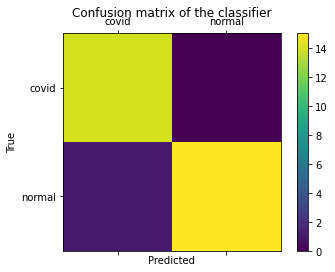

In [0]:
labels = ['covid', 'normal']
cm = confusion_matrix(testY.argmax(axis=1),predY.argmax(axis=1))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

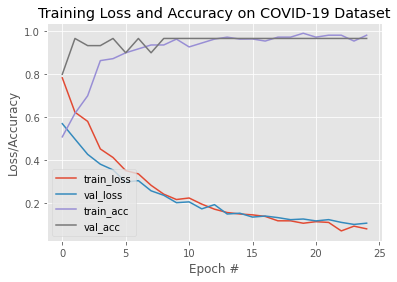

In [0]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("training&validation_accuracy.png")

In [0]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save("model_covid19.h5")

[INFO] saving COVID-19 detector model...


In [0]:
import shutil, random, os, cv2, random

['NORMAL2-IM-1412-0001.jpeg']


In [0]:
from keras.preprocessing.image import img_to_array

[INFO] classifying image...
covid: 11.54%
normal: 88.46%


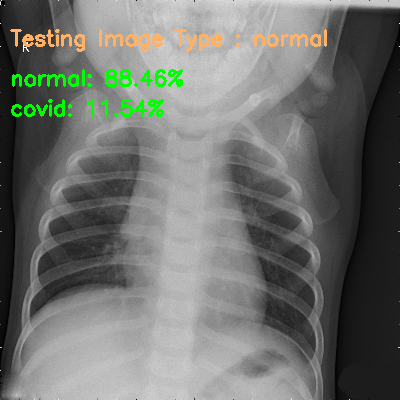

In [0]:
# load the image
import shutil, random, os, cv2, random
dirpath = "//content//two//test"
type_ = random.sample(os.listdir(dirpath), 1)
path = random.sample(os.listdir(os.path.join(dirpath,type_[0])), 1)
#print(path)

# load the image
image = cv2.imread(os.path.join(dirpath,type_[0],path[0]))
output =cv2.resize(image, (400, 400))
# pre-process the image for classification
image = cv2.resize(image, (224, 224))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# classify the input image then find the indexes of the two class
# labels with the *largest* probability
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idxs = np.argsort(proba)[::-1][:2]
from google.colab.patches import cv2_imshow
# loop over the indexes of the high confidence class labels
label = "Testing Image Type : {} ".format(type_[0])
cv2.putText(output, label, (10, (1 * 20) + 25), 
  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (102, 178, 255), 2)
  
for (i, j) in enumerate(idxs):
  # build the label and draw the label on the image
  label = "{}: {:.2f}%".format(lb.classes_[j], proba[j] * 100)
  cv2.putText(output, label, (10, ((i+2) * 30) + 25), 
		cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# show the probabilities for each of the individual labels
for (label, p) in zip(lb.classes_, proba):
	print("{}: {:.2f}%".format(label, p * 100))
# show the output image
cv2_imshow(output)


covid: 9.70%
normal: 90.30%


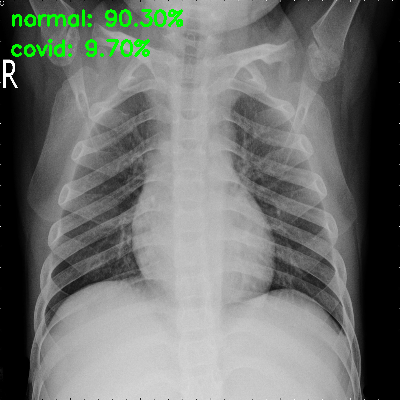

In [0]:
from google.colab import drive
drive.mount('drive')
import os
[x[0] for x in os.walk("drive")]

In [0]:
!cp model_covid19.h5 /content/drive/My\ Drive/covid19_deection
!cp *.png /content/drive/My\ Drive/covid19_deection
!cp Covid_Data_GradientCrescent.zip /content/drive/My\ Drive/covid19_deection